# Практические работы
## 2. Безопасная настройка Vector RAG с использованием Object Storage ##
### Задача: "Развернуть безопасное хранилище документов и настроить его интеграцию с RAG-цепочкой" ###
#### 2.1. Создание бакета и настройка доступа ####
Создайте бакет, например: rag-docs-trusted. <br>
Загрузите в него только доверенные документы (PDF, TXT, позже можно расширить).<br>
Создайте отдельного пользователя/сервисный аккаунт с правами:<br>
<p>Сохраните ACCESS_KEY и SECRET_KEY — они понадобятся для интеграции.</p>

#### 2.2. Настройка .env для интеграции ####
Создайте файл .env в корне проекта:<br>

S3_ENDPOINT=https://storage.yandexcloud.net<br>
S3_ACCESS_KEY=ваш_ключ_только_для_чтения<br>
S3_SECRET_KEY=ваш_секретный_ключ<br>
S3_BUCKET=rag-docs-trusted<br>
S3_PREFIX=docs/  # опционально — папка внутри бакета<br>

#### 2.3. Проверка подключения ####
Добавьте валидацию переменных при запуске:

Алгоритм работы rag системы:
1)   База данных в виде неструктурированных данных нарезается на небольшие куски текста (чанки) – 100-1000 слов (из-за ограничений, накладываемых векторизацией), данный процесс называется чанкованием.
2)   Чанки оцифровываются с помощью эмбэддера (процесс векторизации) и превращаются в эмбэддинги, т. е. вектора (наборы чисел).
3)   Вектора собираются в векторную БД, по которой производится поиск.
4)   Когда пользователь посылает запрос, он эмбэддером кодируется в другие эмбэддинги и по векторной БД ищутся ближайшие соседи.

Промт поступающий в агент делится на пользовательские данные и контент сформированный rag системой.

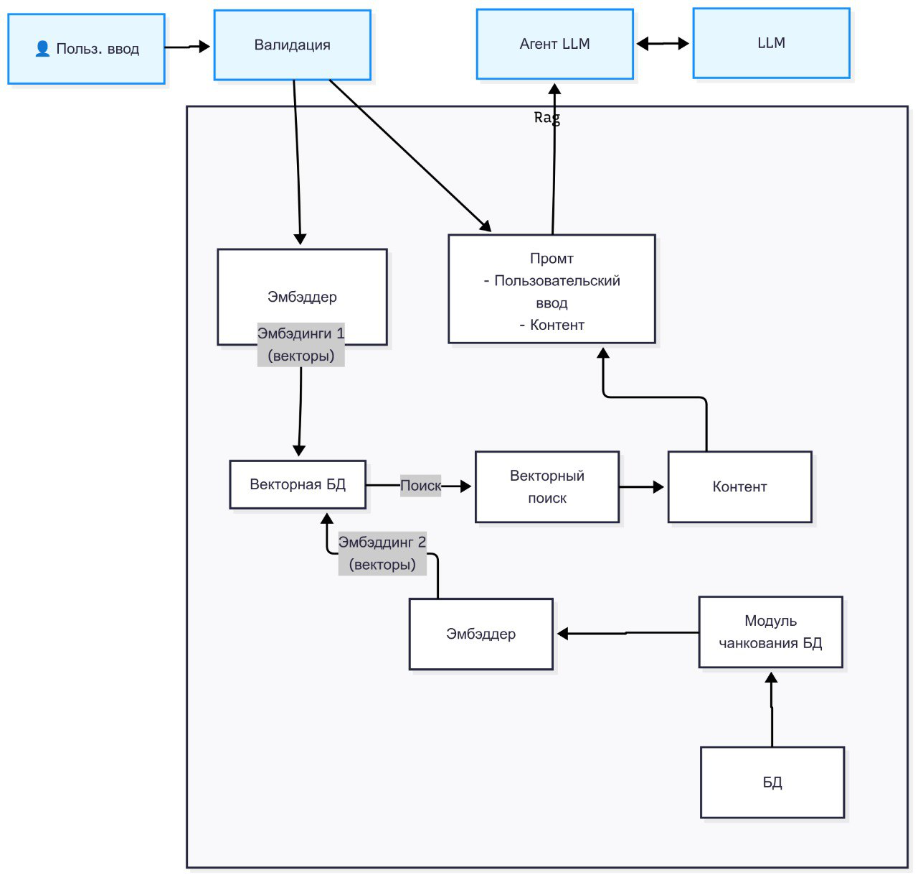

### Задача: Реализовать механизм безопасной загрузки документов ###
Загрузка ≠ индексация. Здесь речь о безопасном скачивании и подготовке документов из хранилища перед индексацией.<br>
Безопасное скачивание<br>

Функция download_from_s3() должна:<br>
1. Проверять, что key — строка, а не None.
2. Пропускать папки (key.endswith('/')).
3. Проверять размер файла до/после скачивания.
4. Ловить исключения при скачивании.
5. Использовать временную директорию.

In [ ]:
def download_from_s3():
    s3 = boto3.client(
        's3',
        endpoint_url=S3_ENDPOINT,
        aws_access_key_id=S3_ACCESS_KEY,
        aws_secret_access_key=S3_SECRET_KEY,
        region_name='ru-central1'
    )

    try:
        objects = s3.list_objects_v2(Bucket=S3_BUCKET, Prefix=S3_PREFIX)
    except Exception as e:
        print(f"Ошибка подключения: {e}")
        return None

    if 'Contents' not in objects:
        return load_and_index_documents([])

    local_files = []
    with tempfile.TemporaryDirectory() as tmpdir:
        for obj in objects['Contents']:
            key = obj.get('Key')
            if not key or not isinstance(key, str) or key.endswith('/'):
                continue

            size = obj.get('Size', 0)
            if size == 0:
                continue

            local_path = os.path.join(tmpdir, os.path.basename(key))
            try:
                s3.download_file(S3_BUCKET, key, local_path)
                if os.path.getsize(local_path) == 0:
                    continue
                local_files.append(local_path)
            except Exception as e:
                print(f"Ошибка скачивания {key}: {e}")
                continue

        return load_and_index_documents(local_files)

#### Валидация содержимого документов ####
Перед индексацией — убедитесь, что page_content:
1. Не None
2. Является строкой
3. Не пустая

In [ ]:
valid_docs = [
    doc for doc in loaded
    if hasattr(doc, 'page_content') and
       isinstance(doc.page_content, str) and
       doc.page_content.strip()
]

#### Обработка ошибок и заглушка ####
Если ни один документ не прошёл валидацию — создаём заглушку:

In [ ]:
if not docs:
    docs = [Document(page_content="Нет доступных документов.", metadata={})]

Это гарантирует, что FAISS всегда создастся, и RAG не сломает бота.
#### Интеграция с RAG-конвейером ####
Архитектура конвейера:<br>
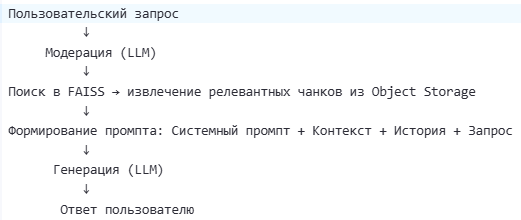

#### Безопасная подстановка контекста ####
1. Контекст вставляется до системного промпта пользователя — не может переопределить инструкции.
1. Используется фиксированный шаблон — пользователь не влияет на структуру.
1. Данные из Object Storage — доверенные, не зависят от ввода пользователя.